# Version history
- V12 - (ENet B7 + DenseNet, best_alpha=0.5) + AugMix + part of Oxford Dataset **(0.96564)**
- V15 - (ENet B7 + DenseNet, best_alpha=0.44) + AugMix + part of Oxford Dataset (0.96194)
- V16 - (ENet B7 + ResNet152V2, best_alpha=0.5) + AugMix + part of Oxford Dataset (0.96013)
- V17 - (V12), EPOCHS 20-> 25 (0.96404)
- V19 - (V12), ENet B7 weights -> noisy-student, no normalization, with validation (0.95663)
- V20 - (V19) with normalization and validation (0.95331)
- V21 - (V19) no validation **(0.96445)**
- V22 - (V21), ENet B7 weights -> imagenet, remove custom params, 30 epochs (0.96375)
- V23 - (V22), Enet for 25 epochs, DenseNet for 20 epochs, kick up augmix level and add normalization (0.96170)


IDEAS: grid mask + cutmix ? 
加上标签平滑？
tf.losses.softmax_cross_entropy(onehot_labels=y, logits=logit, label_smoothing=0.001)

In [1]:
import time
start_time = time.time()
def measure_time(exec_history, event):
    exec_history.append([event, time.time()-start_time])
    return exec_history

exec_history = measure_time([], "Start notebook")


In [2]:
!pip install -q efficientnet

In [3]:
import math, re, os
import tensorflow as tf, tensorflow.keras.backend as K
import tensorflow_probability as tfp
import numpy as np
from matplotlib import pyplot as plt
from kaggle_datasets import KaggleDatasets
import efficientnet.tfkeras as efn
from tensorflow.keras.applications import DenseNet201
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
print("Tensorflow version " + tf.__version__)
AUTO = tf.data.experimental.AUTOTUNE

Tensorflow version 2.1.0


In [4]:
# Detect hardware, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() # default distribution strategy in Tensorflow. Works on CPU and single GPU.

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


In [5]:
GCS_DS_PATH = KaggleDatasets().get_gcs_path('flower-classification-with-tpus') # you can list the bucket with "!gsutil ls $GCS_DS_PATH"
#OXFORD_PATH = KaggleDatasets().get_gcs_path('tf-flower-photo-tfrec')
#OXFORD_PATH = KaggleDatasets().get_gcs_path('oxford-102-for-tpu-competition')

# Configuration

In [6]:
#IMAGE_SIZE = [512, 512] # at this size, a GPU will run out of memory. Use the TPU
IMAGE_SIZE = [331, 331]
EPOCHS = 25

BATCH_SIZE = 24 * strategy.num_replicas_in_sync


GCS_PATH_SELECT = { # available image sizes
    192: GCS_DS_PATH + '/tfrecords-jpeg-192x192',
    224: GCS_DS_PATH + '/tfrecords-jpeg-224x224',
    331: GCS_DS_PATH + '/tfrecords-jpeg-331x331',
    #512: GCS_DS_PATH + '/tfrecords-jpeg-512x512'
}
GCS_PATH = GCS_PATH_SELECT[IMAGE_SIZE[0]]

TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/train/*.tfrec')
TRAINING_FILENAMES_model2 = tf.io.gfile.glob(GCS_PATH + '/train/*.tfrec')

#tf.io.gfile.glob(OXFORD_PATH + '/*.tfrec')
VALIDATION_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/val/*.tfrec')
TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/test/*.tfrec') # predictions on this dataset should be submitted for the competition


In [7]:
GCS_DS_PATH =KaggleDatasets().get_gcs_path('tf-flower-photo-tfrec')


GCS_PATH_SELECT = { # available image sizes
    
    192: GCS_DS_PATH +'/oxford_102/tfrecords-jpeg-192x192/',
    224: GCS_DS_PATH + '/oxford_102/tfrecords-jpeg-224x224/',
    331: GCS_DS_PATH + '/oxford_102/tfrecords-jpeg-331x331/',
      
}

GCS_PATH = GCS_PATH_SELECT[IMAGE_SIZE[0]]

TRAINING_FILENAMES_model2 = TRAINING_FILENAMES_model2 + tf.io.gfile.glob(GCS_PATH + '*.tfrec')



GCS_PATH_SELECT = { # available image sizes

    192: GCS_DS_PATH +'/tf_flowers/tfrecords-jpeg-192x192/',
    224: GCS_DS_PATH + '/tf_flowers/tfrecords-jpeg-224x224/',
    331: GCS_DS_PATH + '/tf_flowers/tfrecords-jpeg-331x331/',
    #512: GCS_DS_PATH + '/tf_flowers/tfrecords-jpeg-512x512/',
    
}


GCS_PATH = GCS_PATH_SELECT[IMAGE_SIZE[0]]

TRAINING_FILENAMES_model2 = TRAINING_FILENAMES_model2 + tf.io.gfile.glob(GCS_PATH + '*.tfrec')


GCS_PATH_SELECT = { # available image sizes
    
    192: GCS_DS_PATH +'/inaturalist/tfrecords-jpeg-192x192/',
    224: GCS_DS_PATH + '/inaturalist/tfrecords-jpeg-224x224/',
    331: GCS_DS_PATH + '/inaturalist/tfrecords-jpeg-331x331/'
}


GCS_PATH = GCS_PATH_SELECT[IMAGE_SIZE[0]]

TRAINING_FILENAMES_model2 = TRAINING_FILENAMES_model2 + tf.io.gfile.glob(GCS_PATH + '*.tfrec')



GCS_PATH_SELECT = { # available image sizes
    
    192: GCS_DS_PATH +'/inaturalist_1/tfrecords-jpeg-192x192/',
    224: GCS_DS_PATH + '/inaturalist_1/tfrecords-jpeg-224x224/',
    331: GCS_DS_PATH + '/inaturalist_1/tfrecords-jpeg-331x331/',
    #512: GCS_DS_PATH + '/inaturalist/tfrecords-jpeg-512x512/',
    
}


GCS_PATH = GCS_PATH_SELECT[IMAGE_SIZE[0]]

TRAINING_FILENAMES_model2 = TRAINING_FILENAMES_model2 + tf.io.gfile.glob(GCS_PATH + '*.tfrec')
'''

GCS_PATH_SELECT = { # available image sizes
    
    192: GCS_DS_PATH +'/openimage/tfrecords-jpeg-192x192/',
    224: GCS_DS_PATH + '/openimage/tfrecords-jpeg-224x224/',
    331: GCS_DS_PATH + '/openimage/tfrecords-jpeg-331x331/',
    #512: GCS_DS_PATH + '/inaturalist/tfrecords-jpeg-512x512/',
    
}

GCS_PATH = GCS_PATH_SELECT[IMAGE_SIZE[0]]

TRAINING_FILENAMES_model2 = TRAINING_FILENAMES_model2 + tf.io.gfile.glob(GCS_PATH + '*.tfrec')
'''

"\n\nGCS_PATH_SELECT = { # available image sizes\n    \n    192: GCS_DS_PATH +'/openimage/tfrecords-jpeg-192x192/',\n    224: GCS_DS_PATH + '/openimage/tfrecords-jpeg-224x224/',\n    331: GCS_DS_PATH + '/openimage/tfrecords-jpeg-331x331/',\n    #512: GCS_DS_PATH + '/inaturalist/tfrecords-jpeg-512x512/',\n    \n}\n\nGCS_PATH = GCS_PATH_SELECT[IMAGE_SIZE[0]]\n\nTRAINING_FILENAMES_model2 = TRAINING_FILENAMES_model2 + tf.io.gfile.glob(GCS_PATH + '*.tfrec')\n"

In [8]:
GCS_DS_PATH =KaggleDatasets().get_gcs_path('tf-flower-photo-tfrec')


GCS_PATH_SELECT = { # available image sizes
    
    192: GCS_DS_PATH +'/oxford_102/tfrecords-jpeg-192x192/',
    224: GCS_DS_PATH + '/oxford_102/tfrecords-jpeg-224x224/',
    331: GCS_DS_PATH + '/oxford_102/tfrecords-jpeg-331x331/',
    #512: GCS_DS_PATH + '/inaturalist/tfrecords-jpeg-512x512/',   
}



GCS_PATH = GCS_PATH_SELECT[IMAGE_SIZE[0]]

TRAINING_FILENAMES = TRAINING_FILENAMES + tf.io.gfile.glob(GCS_PATH + '*.tfrec')


GCS_PATH_SELECT = { # available image sizes
    
    192: GCS_DS_PATH +'/inaturalist/tfrecords-jpeg-192x192/',
    224: GCS_DS_PATH + '/inaturalist/tfrecords-jpeg-224x224/',
    331: GCS_DS_PATH + '/inaturalist/tfrecords-jpeg-331x331/',
    #512: GCS_DS_PATH + '/inaturalist/tfrecords-jpeg-512x512/',
    
}

GCS_PATH = GCS_PATH_SELECT[IMAGE_SIZE[0]]

TRAINING_FILENAMES = TRAINING_FILENAMES + tf.io.gfile.glob(GCS_PATH + '*.tfrec')




GCS_PATH_SELECT = { # available image sizes
    
    192: GCS_DS_PATH +'/inaturalist_1/tfrecords-jpeg-192x192/',
    224: GCS_DS_PATH + '/inaturalist_1/tfrecords-jpeg-224x224/',
    331: GCS_DS_PATH + '/inaturalist_1/tfrecords-jpeg-331x331/',
    
}


GCS_PATH = GCS_PATH_SELECT[IMAGE_SIZE[0]]

TRAINING_FILENAMES = TRAINING_FILENAMES + tf.io.gfile.glob(GCS_PATH + '*.tfrec')

GCS_PATH_SELECT = { # available image sizes
    
    331: GCS_DS_PATH + '/imagenet/tfrecords-jpeg-331x331/'

}


GCS_PATH = GCS_PATH_SELECT[IMAGE_SIZE[0]]

TRAINING_FILENAMES = TRAINING_FILENAMES + tf.io.gfile.glob(GCS_PATH + '*.tfrec')
# VALIDATION_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/val/*.tfrec')
# TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/test/*.tfrec')

GCS_PATH_SELECT = { # available image sizes
    
    192: GCS_DS_PATH +'/tf_flowers/tfrecords-jpeg-192x192/',
    224: GCS_DS_PATH + '/tf_flowers/tfrecords-jpeg-224x224/',
    331: GCS_DS_PATH + '/tf_flowers/tfrecords-jpeg-331x331/',
    512: GCS_DS_PATH + '/tf_flowers/tfrecords-jpeg-512x512/',
}


GCS_PATH = GCS_PATH_SELECT[IMAGE_SIZE[0]]

TRAINING_FILENAMES = TRAINING_FILENAMES + tf.io.gfile.glob(GCS_PATH + '*.tfrec')

# 是否加入验证集

In [9]:
SKIP_VALIDATION = True#True#True #False True
if SKIP_VALIDATION:
    TRAINING_FILENAMES = TRAINING_FILENAMES + VALIDATION_FILENAMES
    TRAINING_FILENAMES_model2 = TRAINING_FILENAMES_model2 + VALIDATION_FILENAMES

In [10]:
CLASSES = ['pink primrose',    'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea',     'wild geranium',     'tiger lily',           'moon orchid',              'bird of paradise', 'monkshood',        'globe thistle',         # 00 - 09
           'snapdragon',       "colt's foot",               'king protea',      'spear thistle', 'yellow iris',       'globe-flower',         'purple coneflower',        'peruvian lily',    'balloon flower',   'giant white arum lily', # 10 - 19
           'fire lily',        'pincushion flower',         'fritillary',       'red ginger',    'grape hyacinth',    'corn poppy',           'prince of wales feathers', 'stemless gentian', 'artichoke',        'sweet william',         # 20 - 29
           'carnation',        'garden phlox',              'love in the mist', 'cosmos',        'alpine sea holly',  'ruby-lipped cattleya', 'cape flower',              'great masterwort', 'siam tulip',       'lenten rose',           # 30 - 39
           'barberton daisy',  'daffodil',                  'sword lily',       'poinsettia',    'bolero deep blue',  'wallflower',           'marigold',                 'buttercup',        'daisy',            'common dandelion',      # 40 - 49
           'petunia',          'wild pansy',                'primula',          'sunflower',     'lilac hibiscus',    'bishop of llandaff',   'gaura',                    'geranium',         'orange dahlia',    'pink-yellow dahlia',    # 50 - 59
           'cautleya spicata', 'japanese anemone',          'black-eyed susan', 'silverbush',    'californian poppy', 'osteospermum',         'spring crocus',            'iris',             'windflower',       'tree poppy',            # 60 - 69
           'gazania',          'azalea',                    'water lily',       'rose',          'thorn apple',       'morning glory',        'passion flower',           'lotus',            'toad lily',        'anthurium',             # 70 - 79
           'frangipani',       'clematis',                  'hibiscus',         'columbine',     'desert-rose',       'tree mallow',          'magnolia',                 'cyclamen ',        'watercress',       'canna lily',            # 80 - 89
           'hippeastrum ',     'bee balm',                  'pink quill',       'foxglove',      'bougainvillea',     'camellia',             'mallow',                   'mexican petunia',  'bromelia',         'blanket flower',        # 90 - 99
           'trumpet creeper',  'blackberry lily',           'common tulip',     'wild rose']                                                                                                                                               # 100 - 102

In [11]:
exec_history = measure_time(exec_history, "Import libraries, initilialize TPU and config")

# Dataset functions

In [12]:
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # explicit size needed for TPU
    return image

def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means single element
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    label = tf.cast(example['class'], tf.int32)
    return image, label # returns a dataset of (image, label) pairs

def read_unlabeled_tfrecord(example):
    UNLABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "id": tf.io.FixedLenFeature([], tf.string),  # shape [] means single element
        # class is missing, this competitions's challenge is to predict flower classes for the test dataset
    }
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    idnum = example['id']
    return image, idnum # returns a dataset of image(s)

def load_dataset(filenames, labeled = True, ordered = False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # Diregarding data order. Order does not matter since we will be shuffling the data anyway
    
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed
        
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads = AUTO) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # use data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord if labeled else read_unlabeled_tfrecord, num_parallel_calls = AUTO) # returns a dataset of (image, label) pairs if labeled = True or (image, id) pair if labeld = False
    return dataset



def data_augment(image, label):  # 训练样本在预读过程中进行数据增强，这部分操作在CPU上
    # data augmentation. Thanks to the dataset.prefetch(AUTO) statement in the next function (below),
    # this happens essentially for free on TPU. Data pipeline code is executed on the "CPU" part
    # of the TPU while the TPU itself is computing gradients.
    image = tf.image.random_flip_left_right(image,seed=42)
    #image = dataset.map(decoded_example)
    #image = augmentation(image)
    
    #image = tf.image.random_saturation(image, 0.4, 2.4)
    return image, label

def data_augment_1(image, label):  # 训练样本在预读过程中进行数据增强，这部分操作在CPU上
    # data augmentation. Thanks to the dataset.prefetch(AUTO) statement in the next function (below),
    # this happens essentially for free on TPU. Data pipeline code is executed on the "CPU" part
    # of the TPU while the TPU itself is computing gradients.
    image = tf.image.random_flip_left_right(image,seed=42)
    #image = dataset.map(decoded_example)
    #image = augmentation(image)
    
    #image = tf.image.random_saturation(image, 0.4, 2.4)
    return image, label



def get_training_dataset():
    dataset = load_dataset(TRAINING_FILENAMES, labeled=True)
    dataset = dataset.map(data_augment_1, num_parallel_calls=AUTO)
    #
    #dataset = dataset.map(decoded_example)
    #dataset = dataset.map(augmentation)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_training_dataset_model2():
    dataset = load_dataset(TRAINING_FILENAMES_model2, labeled=True)
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    #
    #dataset = dataset.map(decoded_example)
    #dataset = dataset.map(augmentation)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_validation_dataset(ordered=False):
    dataset = load_dataset(VALIDATION_FILENAMES, labeled=True, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE) # slighly faster with fixed tensor sizes
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_test_dataset(ordered=False):
    dataset = load_dataset(TEST_FILENAMES, labeled=False, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def count_data_items(filenames):
    # the number of data items is written in the name of the .tfrec files, i.e. flowers00-230.tfrec = 230 data items
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)


# Data visualization

In [13]:
# numpy and matplotlib defaults
np.set_printoptions(threshold=15, linewidth=80)

def batch_to_numpy_images_and_labels(data):
    images, labels = data 
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    if numpy_labels.dtype == object: # binary string in this case, these are image ID strings
        numpy_labels = [None for _ in enumerate(numpy_images)]
    # If no labels, only image IDs, return None for labels (this is the case for test data)
    return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
    if correct_label is None:
        return CLASSES[label], True
    correct = (label == correct_label)
    return "{} [{}{}{}]".format(CLASSES[label], 'OK' if correct else 'NO', u"\u2192" if not correct else '',
                                CLASSES[correct_label] if not correct else ''), correct

def display_one_flower(image, title, subplot, red=False, titlesize=16):
    plt.subplot(*subplot)
    plt.axis('off')
    plt.imshow(image)
    if len(title) > 0:
        plt.title(title, fontsize=int(titlesize) if not red else int(titlesize/1.2), color='red' if red else 'black', fontdict={'verticalalignment':'center'}, pad=int(titlesize/1.5))
    return (subplot[0], subplot[1], subplot[2]+1)
    
def display_batch_of_images(databatch, predictions=None, figsize  = 13.0):
    """This will work with:
    display_batch_of_images(images)
    display_batch_of_images(images, predictions)
    display_batch_of_images((images, labels))
    display_batch_of_images((images, labels), predictions)
    """
    # data
    images, labels = batch_to_numpy_images_and_labels(databatch)
    if labels is None:
        labels = [None for _ in enumerate(images)]
        
    # auto-squaring: this will drop data that does not fit into square or square-ish rectangle
    rows = int(math.sqrt(len(images)))
    cols = len(images)//rows
        
    # size and spacing
    FIGSIZE =  figsize
    SPACING = 0.1
    subplot=(rows,cols,1)
    if rows < cols:
        plt.figure(figsize=(FIGSIZE,FIGSIZE/cols*rows))
    else:
        plt.figure(figsize=(FIGSIZE/rows*cols,FIGSIZE))
    
    # display
    for i, (image, label) in enumerate(zip(images[:rows*cols], labels[:rows*cols])):
        title = '' if label is None else CLASSES[label]
        correct = True
        if predictions is not None:
            title, correct = title_from_label_and_target(predictions[i], label)
        dynamic_titlesize = FIGSIZE*SPACING/max(rows,cols)*40+3 # magic formula tested to work from 1x1 to 10x10 images
        subplot = display_one_flower(image, title, subplot, not correct, titlesize=dynamic_titlesize)
    
    #layout
    plt.tight_layout()
    if label is None and predictions is None:
        plt.subplots_adjust(wspace=0, hspace=0)
    else:
        plt.subplots_adjust(wspace=SPACING, hspace=SPACING)
    plt.show()

def display_confusion_matrix(cmat, score, precision, recall):
    plt.figure(figsize=(15,15))
    ax = plt.gca()
    ax.matshow(cmat, cmap='Reds')
    ax.set_xticks(range(len(CLASSES)))
    ax.set_xticklabels(CLASSES, fontdict={'fontsize': 7})
    plt.setp(ax.get_xticklabels(), rotation=45, ha="left", rotation_mode="anchor")
    ax.set_yticks(range(len(CLASSES)))
    ax.set_yticklabels(CLASSES, fontdict={'fontsize': 7})
    plt.setp(ax.get_yticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    titlestring = ""
    if score is not None:
        titlestring += 'f1 = {:.3f} '.format(score)
    if precision is not None:
        titlestring += '\nprecision = {:.3f} '.format(precision)
    if recall is not None:
        titlestring += '\nrecall = {:.3f} '.format(recall)
    if len(titlestring) > 0:
        ax.text(101, 1, titlestring, fontdict={'fontsize': 18, 'horizontalalignment':'right', 'verticalalignment':'top', 'color':'#804040'})
    plt.show()
    
def display_training_curves(training, validation, title, subplot):
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    #ax.set_ylim(0.28,1.05)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

# Data augmentation

## Transformations

In [14]:
#一种数据增强方式
AugParams = {
    'd1' : 90,
    'd2': 160,
    'rotate' : 280,
    'ratio' : 0.45
    }


def transform(image, inv_mat, image_shape):

      h, w, c = image_shape
      cx, cy = w//2, h//2

      new_xs = tf.repeat( tf.range(-cx, cx, 1), h)
      new_ys = tf.tile( tf.range(-cy, cy, 1), [w])
      new_zs = tf.ones([h*w], dtype=tf.int32)

      old_coords = tf.matmul(inv_mat, tf.cast(tf.stack([new_xs, new_ys, new_zs]), tf.float32))
      old_coords_x, old_coords_y = tf.round(old_coords[0, :] + w//2), tf.round(old_coords[1, :] + h//2)

      clip_mask_x = tf.logical_or(old_coords_x<0, old_coords_x>w-1)
      clip_mask_y = tf.logical_or(old_coords_y<0, old_coords_y>h-1)
      clip_mask = tf.logical_or(clip_mask_x, clip_mask_y)

      old_coords_x = tf.boolean_mask(old_coords_x, tf.logical_not(clip_mask))
      old_coords_y = tf.boolean_mask(old_coords_y, tf.logical_not(clip_mask))
      new_coords_x = tf.boolean_mask(new_xs+cx, tf.logical_not(clip_mask))
      new_coords_y = tf.boolean_mask(new_ys+cy, tf.logical_not(clip_mask))

      old_coords = tf.cast(tf.stack([old_coords_y, old_coords_x]), tf.int32)
      new_coords = tf.cast(tf.stack([new_coords_y, new_coords_x]), tf.int64)
      rotated_image_values = tf.gather_nd(image, tf.transpose(old_coords))
      rotated_image_channel = list()
      for i in range(c):
          vals = rotated_image_values[:,i]
          sparse_channel = tf.SparseTensor(tf.transpose(new_coords), vals, [h, w])
          rotated_image_channel.append(tf.sparse.to_dense(sparse_channel, default_value=0, validate_indices=False))

      return tf.transpose(tf.stack(rotated_image_channel), [1,2,0])

def random_rotate(image, angle, image_shape):

    def get_rotation_mat_inv(angle):
          #transform to radian
          angle = math.pi * angle / 180

          cos_val = tf.math.cos(angle)
          sin_val = tf.math.sin(angle)
          one = tf.constant([1], tf.float32)
          zero = tf.constant([0], tf.float32)

          rot_mat_inv = tf.concat([cos_val, sin_val, zero,
                                     -sin_val, cos_val, zero,
                                     zero, zero, one], axis=0)
          rot_mat_inv = tf.reshape(rot_mat_inv, [3,3])

          return rot_mat_inv
    angle = float(angle) * tf.random.normal([1],dtype='float32')
    rot_mat_inv = get_rotation_mat_inv(angle)
    return transform(image, rot_mat_inv, image_shape)


def GridMask(image_height, image_width, d1, d2, rotate_angle=1, ratio=0.5):

    h, w = image_height, image_width
    hh = int(np.ceil(np.sqrt(h*h+w*w)))
    hh = hh+1 if hh%2==1 else hh
    d = tf.random.uniform(shape=[], minval=d1, maxval=d2, dtype=tf.int32)
    l = tf.cast(tf.cast(d,tf.float32)*ratio+0.5, tf.int32)

    st_h = tf.random.uniform(shape=[], minval=0, maxval=d, dtype=tf.int32)
    st_w = tf.random.uniform(shape=[], minval=0, maxval=d, dtype=tf.int32)

    y_ranges = tf.range(-1 * d + st_h, -1 * d + st_h + l)
    x_ranges = tf.range(-1 * d + st_w, -1 * d + st_w + l)

    for i in range(0, hh//d+1):
        s1 = i * d + st_h
        s2 = i * d + st_w
        y_ranges = tf.concat([y_ranges, tf.range(s1,s1+l)], axis=0)
        x_ranges = tf.concat([x_ranges, tf.range(s2,s2+l)], axis=0)

    x_clip_mask = tf.logical_or(x_ranges <0 , x_ranges > hh-1)
    y_clip_mask = tf.logical_or(y_ranges <0 , y_ranges > hh-1)
    clip_mask = tf.logical_or(x_clip_mask, y_clip_mask)

    x_ranges = tf.boolean_mask(x_ranges, tf.logical_not(clip_mask))
    y_ranges = tf.boolean_mask(y_ranges, tf.logical_not(clip_mask))

    hh_ranges = tf.tile(tf.range(0,hh), [tf.cast(tf.reduce_sum(tf.ones_like(x_ranges)), tf.int32)])
    x_ranges = tf.repeat(x_ranges, hh)
    y_ranges = tf.repeat(y_ranges, hh)

    y_hh_indices = tf.transpose(tf.stack([y_ranges, hh_ranges]))
    x_hh_indices = tf.transpose(tf.stack([hh_ranges, x_ranges]))

    y_mask_sparse = tf.SparseTensor(tf.cast(y_hh_indices, tf.int64),  tf.zeros_like(y_ranges), [hh, hh])
    y_mask = tf.sparse.to_dense(y_mask_sparse, 1, False)

    x_mask_sparse = tf.SparseTensor(tf.cast(x_hh_indices, tf.int64), tf.zeros_like(x_ranges), [hh, hh])
    x_mask = tf.sparse.to_dense(x_mask_sparse, 1, False)

    mask = tf.expand_dims( tf.clip_by_value(x_mask + y_mask, 0, 1), axis=-1)

    mask = random_rotate(mask, rotate_angle, [hh, hh, 1])
    mask = tf.image.crop_to_bounding_box(mask, (hh-h)//2, (hh-w)//2, image_height, image_width)

    return mask

def apply_grid_mask(image, image_shape):
    mask = GridMask(image_shape[0],
                    image_shape[1],
                    AugParams['d1'],
                    AugParams['d2'],
                    AugParams['rotate'],
                    AugParams['ratio'])
    
    if image_shape[-1] == 3:
        mask = tf.concat([mask, mask, mask], axis=-1)
    return image * tf.cast(mask, tf.float32)

    
def augmentation(image):    
    if tf.random.uniform(shape=[], minval=0.0, maxval=1.0) >=0.5:
        image = apply_grid_mask(image, (*IMAGE_SIZE,3))        
    return image#tf.cast(image, tf.uint8) #image, label 

In [15]:
exec_history = measure_time(exec_history, "Initialize dataset, visualization and augmentation functions")

## Visualize augmentation

In [16]:
show_me = False
if show_me:
    dataset = get_training_dataset()
    training_dataset = dataset.unbatch().batch(20)
    train_batch = iter(training_dataset)
    display_batch_of_images(next(train_batch))


# Custom LR scheduler

Learning rate schedule: 8e-05 to 0.00036 to 1.05e-05


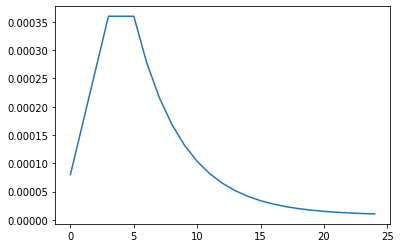

In [17]:
# Learning rate schedule for TPU, GPU and CPU.
# Using an LR ramp up because fine-tuning a pre-trained model.
# Starting with a high LR would break the pre-trained weights.
def lrfn(epoch):
    
    LR_START = 0.00008
#LR_START = 0.00001
    LR_MAX = 0.000045 * strategy.num_replicas_in_sync
    LR_MIN = 0.000008
    LR_RAMPUP_EPOCHS = 3
    LR_SUSTAIN_EPOCHS = 2
    LR_EXP_DECAY = .77
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = True)

rng = [i for i in range(EPOCHS)]
y = [lrfn(x) for x in rng]
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

Learning rate schedule: 8e-05 to 0.0004 to 1.01e-05


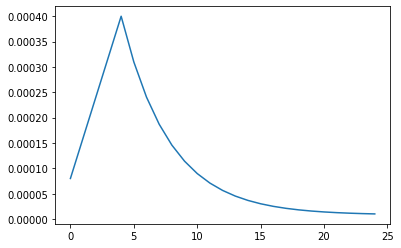

In [18]:
def esfn(epoch):
    LR_START = 0.00008
    LR_MAX = 0.00005 * strategy.num_replicas_in_sync
    LR_MIN = 0.000008
    LR_RAMPUP_EPOCHS = 4
    LR_SUSTAIN_EPOCHS = 0
    LR_EXP_DECAY = .77
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr
    
es_callback = tf.keras.callbacks.LearningRateScheduler(esfn, verbose = True)

rng = [i for i in range(EPOCHS)]
y = [esfn(x) for x in rng]
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

# Training model

In [19]:
NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)
NUM_TRAINING_IMAGES_model2 = count_data_items(TRAINING_FILENAMES_model2)

NUM_VALIDATION_IMAGES = count_data_items(VALIDATION_FILENAMES)
NUM_TEST_IMAGES = count_data_items(TEST_FILENAMES)

STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE
STEPS_PER_EPOCH_model2 = NUM_TRAINING_IMAGES_model2 // BATCH_SIZE

print('Dataset: {} training_1 images, {} training_2 images, {} validation images, {} unlabeled test images'.format(NUM_TRAINING_IMAGES, NUM_TRAINING_IMAGES_model2,NUM_VALIDATION_IMAGES, NUM_TEST_IMAGES))

Dataset: 64104 training_1 images, 34477 training_2 images, 3712 validation images, 7382 unlabeled test images


In [20]:
exec_history = measure_time(exec_history, "Begin downloading ENet B7")

### EfficientNet B7

In [21]:
# efficient net
with strategy.scope():
    enet = efn.EfficientNetB7(
        input_shape=(*IMAGE_SIZE, 3),
        weights='noisy-student',
        include_top=False
    )
    enet.trainable = True

    model = tf.keras.Sequential([
        enet,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(len(CLASSES), activation='softmax')
    ])
        
model.compile(
    optimizer = tf.keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name='Nadam'),
    loss = 'sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)
model.summary()


258072576/258068648 [==============================] - 17s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b7 (Model)      (None, 11, 11, 2560)      64097680  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2560)              0         
_________________________________________________________________
dense (Dense)                (None, 104)               266344    
Total params: 64,364,024
Trainable params: 64,053,304
Non-trainable params: 310,720
_________________________________________________________________


In [22]:
exec_history = measure_time(exec_history, "Finish downloading ENet B7, start training ENet B7")

In [23]:
history = model.fit(
    get_training_dataset(), 
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=EPOCHS,
    callbacks=[lr_callback],
    validation_data=None if SKIP_VALIDATION else get_validation_dataset()
)

Train for 333 steps

Epoch 00001: LearningRateScheduler reducing learning rate to 8e-05.
Epoch 1/25
333/333 [==============================] - 528s 2s/step - loss: 2.1833 - sparse_categorical_accuracy: 0.5008

Epoch 00002: LearningRateScheduler reducing learning rate to 0.00017333333333333334.
Epoch 2/25
333/333 [==============================] - 210s 631ms/step - loss: 0.6731 - sparse_categorical_accuracy: 0.8295

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0002666666666666667.
Epoch 3/25
333/333 [==============================] - 210s 631ms/step - loss: 0.3837 - sparse_categorical_accuracy: 0.8989

Epoch 00004: LearningRateScheduler reducing learning rate to 0.00036.
Epoch 4/25
333/333 [==============================] - 209s 626ms/step - loss: 0.2901 - sparse_categorical_accuracy: 0.9185

Epoch 00005: LearningRateScheduler reducing learning rate to 0.00036.
Epoch 5/25
333/333 [==============================] - 210s 631ms/step - loss: 0.2196 - sparse_categorical_acc

In [24]:
exec_history = measure_time(exec_history, "Finish training ENet B7")

In [25]:
if not SKIP_VALIDATION:
    display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 211)
    display_training_curves(history.history['sparse_categorical_accuracy'], history.history['val_sparse_categorical_accuracy'], 'accuracy', 212)

### DenseNet201

In [26]:
exec_history = measure_time(exec_history, "Begin downloading DenseNet 201")

In [27]:
with strategy.scope():
    dnet = DenseNet201(
        input_shape=(*IMAGE_SIZE, 3),
        weights='imagenet',
        include_top=False
    )
    dnet.trainable = True

    model2 = tf.keras.Sequential([
        dnet,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(len(CLASSES), activation='softmax')
    ])
        
model2.compile(
    optimizer= tf.keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name='Nadam'),
    loss = 'sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)
model2.summary()
    

74842112/74836368 [==============================] - 1s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Model)          (None, 10, 10, 1920)      18321984  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1920)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 104)               199784    
Total params: 18,521,768
Trainable params: 18,292,712
Non-trainable params: 229,056
_________________________________________________________________


In [28]:
exec_history = measure_time(exec_history, "Finish downloading DenseNet 201, start training DenseNet 201")

In [29]:
history2 = model2.fit(
    get_training_dataset_model2(), 
    steps_per_epoch=STEPS_PER_EPOCH_model2,
    epochs=EPOCHS, 
    callbacks=[es_callback],
    validation_data=None if SKIP_VALIDATION else get_validation_dataset()
)

Train for 179 steps

Epoch 00001: LearningRateScheduler reducing learning rate to 8e-05.
Epoch 1/25
179/179 [==============================] - 356s 2s/step - loss: 1.3468 - sparse_categorical_accuracy: 0.7237

Epoch 00002: LearningRateScheduler reducing learning rate to 0.00016.
Epoch 2/25
179/179 [==============================] - 76s 425ms/step - loss: 0.3337 - sparse_categorical_accuracy: 0.9276

Epoch 00003: LearningRateScheduler reducing learning rate to 0.00024000000000000003.
Epoch 3/25
179/179 [==============================] - 74s 416ms/step - loss: 0.1758 - sparse_categorical_accuracy: 0.9567

Epoch 00004: LearningRateScheduler reducing learning rate to 0.00032.
Epoch 4/25
179/179 [==============================] - 76s 426ms/step - loss: 0.1420 - sparse_categorical_accuracy: 0.9609

Epoch 00005: LearningRateScheduler reducing learning rate to 0.0004.
Epoch 5/25
179/179 [==============================] - 76s 427ms/step - loss: 0.1310 - sparse_categorical_accuracy: 0.9688

Epoc

In [30]:
exec_history = measure_time(exec_history, "Finish training DenseNet 201")

In [31]:
if not SKIP_VALIDATION:
    display_training_curves(history2.history['loss'], history2.history['val_loss'], 'loss', 211)
    display_training_curves(history2.history['sparse_categorical_accuracy'], history2.history['val_sparse_categorical_accuracy'], 'accuracy', 212)

### Validation

In [32]:
if not SKIP_VALIDATION:
    from sklearn.metrics import classification_report
    from sklearn.metrics import accuracy_score


    def show_report(model):
        val_dataset = load_dataset(VALIDATION_FILENAMES, labeled=False, ordered=True)

        val_dataset = val_dataset.batch(BATCH_SIZE)
        val_dataset = val_dataset.prefetch(AUTO)
        #val_images_ds = val_dataset.map(normalize_testset)
        val_images_ds = val_dataset.map(lambda image, idnum: image)

        val_dataset2 = load_dataset(VALIDATION_FILENAMES, labeled=True, ordered=True)
        val_labels_ds = [ label.numpy() for image, label in val_dataset2]
        # val_names_ds = val_labels_ds.map(lambda idnum: CLASSES[idnum])

        print("[INFO] evaluating...")
        probabilities = model.predict(val_images_ds)
        predictions = np.argmax(probabilities, axis=-1)
        print(classification_report(val_labels_ds, predictions, target_names=CLASSES))

        # # compute the raw accuracy with extra precision
        acc = accuracy_score(val_labels_ds, predictions)
        print("[INFO] score: {}".format(acc))

    show_report(model)
    show_report(model2)

In [33]:
if not SKIP_VALIDATION: 
    cmdataset = get_validation_dataset(ordered=True) # since we are splitting the dataset and iterating separately on images and labels, order matters.    
    images_ds = cmdataset.map(lambda image, label: image)
    labels_ds = cmdataset.map(lambda image, label: label).unbatch()
    cm_correct_labels = next(iter(labels_ds.batch(NUM_VALIDATION_IMAGES))).numpy() # get everything as one batch
    m = model.predict(images_ds)
    m2 = model2.predict(images_ds)
    scores = []
    for alpha in np.linspace(0,1,100):
        cm_probabilities = alpha*m+(1-alpha)*m2
    #cm_probabilities = (model.predict(images_ds)*0.3)+model2.predict(images_ds)*0.7 
        cm_predictions = np.argmax(cm_probabilities, axis=-1)
        scores.append(f1_score(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)), average='macro'))
    print("Correct   labels: ", cm_correct_labels.shape, cm_correct_labels)
    print("Predicted labels: ", cm_predictions.shape, cm_predictions)
    plt.plot(scores)
    best_alpha = np.argmax(scores)/100
    cm_probabilities = best_alpha*m  +  (1-best_alpha)*m2
    cm_predictions = np.argmax(cm_probabilities, axis=-1)
else:
    best_alpha = 0.53

In [34]:
print(best_alpha)

0.53


Confusion matrix

In [35]:
if not SKIP_VALIDATION:
    cmat = confusion_matrix(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)))
    score = f1_score(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)), average='macro')
    precision = precision_score(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)), average='macro')
    recall = recall_score(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)), average='macro')
    #cmat = (cmat.T / cmat.sum(axis=1)).T # normalized
    display_confusion_matrix(cmat, score, precision, recall)
    print('f1 score: {:.3f}, precision: {:.3f}, recall: {:.3f}'.format(score, precision, recall))

# Predictions

In [36]:
exec_history = measure_time(exec_history, "Start calculating predictions")

In [37]:
test_dataset = get_test_dataset(ordered=True) # since we are splitting the dataset and iterating separately on images and ids, order matters.

print('Computing predictions...')
test_images_ds = test_dataset.map(lambda image, idnum: image)
probabilities = best_alpha*model.predict(test_images_ds) + (1-best_alpha)*model2.predict(test_images_ds)
predictions = np.argmax(probabilities, axis=-1)
print(predictions)

print('Generating submission.csv file...')
test_ids_ds = test_dataset.map(lambda image, idnum: idnum).unbatch()
test_ids = next(iter(test_ids_ds.batch(NUM_TEST_IMAGES))).numpy().astype('U') # all in one batch
np.savetxt('submission.csv', np.rec.fromarrays([test_ids, predictions]), fmt=['%s', '%d'], delimiter=',', header='id,label', comments='')

Computing predictions...
[ 67  28  83 ...  95 102  62]
Generating submission.csv file...


In [38]:
exec_history = measure_time(exec_history, "Finish calculating predictions")

for event in exec_history:
    print(f'{event[1]:7.2f}s - {event[0]}')

   0.00s - Start notebook
  22.01s - Import libraries, initilialize TPU and config
  22.16s - Initialize dataset, visualization and augmentation functions
  22.58s - Begin downloading ENet B7
 112.89s - Finish downloading ENet B7, start training ENet B7
5698.45s - Finish training ENet B7
5698.47s - Begin downloading DenseNet 201
5763.31s - Finish downloading DenseNet 201, start training DenseNet 201
7956.97s - Finish training DenseNet 201
7957.04s - Start calculating predictions
8199.08s - Finish calculating predictions
